In [152]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import IPython
import IPython.display
import pandas as pd
import numpy as np
import math
import scipy
import tempfile
import statsmodels.formula.api as smf
import statsmodels.api as sm
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, MinMaxScaler

# Make numpcy values easier to read.
np.set_printoptions(precision=3, suppress=True)

import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras import layers
from tensorflow.keras.utils import to_categorical #type: ignore
import matplotlib.pyplot as plt
import matplotlib as mat
#import colordict as cd
import seaborn as sns

from flowability_data_upload.Research import main
from flowability_data_upload.Research.main import trymodel, makemodel, modeltest

from statsmodels.graphics.regressionplots import abline_plot

from flowability_data_upload.Research.main import trymodel, makemodel, modeltest, Data

import matplotlib.pyplot as plt
from matplotlib import cm  
from mpl_toolkits.mplot3d import Axes3D


In [153]:
%matplotlib inline  
%matplotlib notebook

In [154]:
%%capture

def load_data():
    x = Data()
    x.importnewpowders()
    df_data = pd.DataFrame(x.data)
    df_flow = pd.DataFrame(x.flow)
    df_noflow = pd.DataFrame(x.noflow)

    return df_data, df_flow, df_noflow

df_data, df_flow, df_noflow = load_data()

In [155]:
pd.set_option('display.max_columns', None)
df_data.describe()

,Da,Dp,FWidth,FLength,ELength,EWidth,Volume,Area,Perimeter,CHull Area,CHull Perimeter,Sphericity,Compactness,Roundness,Ellipse Ratio,Circularity,Solidity,Concavity,Convexity,Extent,Transparency,Curvature,Surface Area,L/W Ratio,W/L Aspect Ratio,CHull Surface Area,Ellipticity,Flow,Flow Class
count,271433.000000,271433.000000,271433.000000,271433.000000,271433.000000,271433.000000,2.714330e+05,271433.000000,271433.000000,271433.000000,271433.000000,271433.000000,271433.000000,271433.000000,271433.000000,271433.000000,271433.000000,271433.000000,271433.000000,271433.000000,271433.000000,271433.000000,271433.000000,271433.000000,271433.000000,271433.000000,271433.000000,271433.000000,271433.000000
mean,17.437426,19.584505,16.006094,20.989617,20.064784,15.574809,1.194712e+04,394.803286,61.526533,417.306852,58.768829,0.899650,0.831908,0.699995,0.794656,0.813635,0.944927,0.055073,0.969058,0.711475,0.369702,0.030291,1579.213144,1.348371,0.769345,1669.227407,1.321048,17.321739,0.557965
std,14.093120,16.539802,12.996290,17.264877,17.008509,12.737594,8.588047e+04,897.617276,51.961316,966.819265,47.467115,0.065308,0.089029,0.141272,0.148346,0.112077,0.046066,0.046066,0.034497,0.052250,0.059026,0.205644,3590.469105,0.303105,0.129415,3867.277062,0.359398,19.867035,0.496630
min,2.579000,3.620000,3.000000,3.840000,2.950000,2.067000,8.985000e+00,5.225000,11.373000,7.423000,11.046000,0.435000,0.291000,0.084000,0.098000,0.189000,0.700000,0.000000,0.548000,0.380000,0.000000,0.000000,20.900000,1.015000,0.124000,29.692000,1.000000,0.000000,0.000000
25%,8.120000,8.978000,7.462000,9.802000,9.166000,7.170000,2.803440e+02,51.787000,28.206000,54.896000,27.675000,0.867000,0.780000,0.608000,0.709000,0.752000,0.928000,0.024000,0.959000,0.686000,0.333000,0.000000,207.147000,1.150000,0.693000,219.583000,1.097000,0.000000,0.000000
50%,12.486000,13.765000,11.378000,14.978000,14.183000,11.128000,1.019258e+03,122.447000,43.244000,129.397000,42.106000,0.917000,0.850000,0.722000,0.832000,0.841000,0.958000,0.042000,0.982000,0.722000,0.383000,0.000000,489.787000,1.255000,0.797000,517.590000,1.201000,14.430000,1.000000
75%,22.466000,24.995000,20.670000,26.623000,25.589000,20.080000,5.936972e+03,396.400000,78.524000,419.254000,75.287000,0.949000,0.900000,0.810000,0.911000,0.900000,0.976000,0.072000,0.992000,0.748000,0.416000,0.000000,1585.602000,1.442000,0.869000,1677.015000,1.410000,34.310000,1.000000
max,395.289000,841.622000,375.143000,514.872000,473.644000,371.279000,3.234010e+07,122720.860000,2644.034000,145923.674000,1448.384000,0.993000,0.987000,0.974000,1.000000,0.986000,1.000000,0.300000,1.000000,0.894000,0.674000,6.250000,490883.440000,8.085000,0.985000,583694.696000,10.246000,64.303333,1.000000


# Training Classifiers

## Flow Class Prediction

In [156]:
#Flow Class Imbalance

neg, pos = np.bincount(df_data['Flow Class']) #type: ignore
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 271433
    Positive: 151450 (55.80% of total)



### Data Cleaning

In [157]:
cleaned_df = df_data.copy().reset_index(drop = True)
powder = cleaned_df.pop('Flow')
powder = cleaned_df.pop('Powder')

## Model Class

In [158]:
class Model:
    def __init__(self, name, num_classes = 2):
        self.name = name
        self.num_classes = num_classes

        self.EPOCHS = 100
        self.BATCH_SIZE = 2048
        

In [159]:
regular_model = Model(name = "Regular")
boxcox_model = Model(name="Boxcox Transform")

### Train Test Split

In [160]:
def split_transform_data(self, cleaned_df, target = 'Flow Class', use_boxcox = False):
    # Use a utility from sklearn to split and shuffle your dataset.
    train_df, self.test_df = train_test_split(cleaned_df, test_size=0.2)

    if use_boxcox:
        for col in train_df.columns[:-1]: #all except last (assuming target)
            fit_values, fit_lambda = scipy.stats.boxcox(train_df[col].values + 0.0001)
            train_df[col] = fit_values
            self.test_df[col] = scipy.stats.boxcox(self.test_df[col].values + 0.0001, fit_lambda)

    self.train_df, self.val_df = train_test_split(train_df, test_size=0.2)

    # Form np arrays of labels and features.
    self.train_labels = np.array(self.train_df.pop(target))
    self.bool_train_labels = self.train_labels != 0
    self.val_labels = np.array(self.val_df.pop(target))
    self.test_labels = np.array(self.test_df.pop(target))

    self.train_features = np.array(self.train_df)
    self.val_features = np.array(self.val_df)
    self.test_features = np.array(self.test_df)
      

Model.split_transform_data = split_transform_data

In [161]:
regular_model.split_transform_data(cleaned_df, use_boxcox=False)
boxcox_model.split_transform_data(cleaned_df, use_boxcox=True)

### Apply Standard Scaling

In [162]:
def apply_StandardScaler(self):
    scaler = MinMaxScaler()
    self.train_features = scaler.fit_transform(self.train_features)

    self.val_features = scaler.transform(self.val_features)
    self.test_features = scaler.transform(self.test_features)

    self.train_features = np.clip(self.train_features, -5, 5)
    self.val_features = np.clip(self.val_features, -5, 5)
    self.test_features = np.clip(self.test_features, -5, 5)


    print('Training labels shape:', self.train_labels.shape)
    print('Validation labels shape:', self.val_labels.shape)
    print('Test labels shape:', self.test_labels.shape)

    print('Training features shape:', self.train_features.shape)
    print('Validation features shape:', self.val_features.shape)
    print('Test features shape:', self.test_features.shape)

Model.apply_StandardScaler = apply_StandardScaler

In [163]:
regular_model.apply_StandardScaler()
boxcox_model.apply_StandardScaler()

Training labels shape: (173716,)
Validation labels shape: (43430,)
Test labels shape: (54287,)
Training features shape: (173716, 27)
Validation features shape: (43430, 27)
Test features shape: (54287, 27)
Training labels shape: (173716,)
Validation labels shape: (43430,)
Test labels shape: (54287,)
Training features shape: (173716, 27)
Validation features shape: (43430, 27)
Test features shape: (54287, 27)


### Define Model and Metrics

In [164]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

Model.METRICS = METRICS

def make_model(self, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    self.model = keras.Sequential([
      keras.layers.Dense(
          16, activation='relu',
          input_shape=(self.train_features.shape[-1],)),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

    self.model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=self.METRICS)

    return self.model

Model.make_model = make_model

def evaluate_model(self):
    results = self.model.evaluate(self.train_features, self.train_labels, batch_size = self.BATCH_SIZE, verbose=0)
    print("Loss: {:0.4f}".format(results[0]))

Model.evaluate_model = evaluate_model

def fit_model(self):

    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_prc', 
        verbose=1,
        patience=10,
        mode='max',
        restore_best_weights=True)

    self.history = self.model.fit(
        self.train_features,
        self.train_labels,
        batch_size=self.BATCH_SIZE,
        epochs=self.EPOCHS,
        callbacks=[early_stopping],
        validation_data=(self.val_features, self.val_labels))

    return self.history

Model.fit_model = fit_model

def predict(self, input):
    # make predictions on the input data using the model
    scaler = StandardScaler()
    scaled_input = scaler.fit_transform(input)

    predictions = self.model.predict(scaled_input)
    
    return predictions

Model.predict = predict
  
def create_model():

    model = keras.Sequential([
      keras.layers.Dense(
          16, activation='relu',
          input_shape=(27,)),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid'),
  ])

    model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=METRICS)

    return model

### Visualization

In [165]:
def visualize(self):
    pos_df = pd.DataFrame(self.train_features[self.bool_train_labels], columns=self.train_df.columns)
    neg_df = pd.DataFrame(self.train_features[~self.bool_train_labels], columns=self.train_df.columns)

    f1,f2 = np.random.choice(self.train_df.columns, 2, replace=False)

    sns.jointplot(x=pos_df[f1], y=pos_df[f2],
                kind='hex', xlim=(-5,5), ylim=(-5,5))
    plt.suptitle("Positive distribution")

    sns.jointplot(x=neg_df[f1], y=neg_df[f2],
                kind='hex', xlim=(-5,5), ylim=(-5,5))
    _ = plt.suptitle("Negative distribution")

Model.visualize = visualize

def plot_metrics(self):

    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    metrics = ['loss', 'prc', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(self.history.epoch, self.history.history[metric], color=colors[0], label='Train')
        plt.plot(self.history.epoch, self.history.history['val_'+metric],
                 color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8,1])
        else:
            plt.ylim([0,1])

    plt.legend()

Model.plot_metrics = plot_metrics

def plot_cm(self, p=0.5):
    predictions = self.model.predict(self.test_features)
    cm = confusion_matrix(self.test_labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('No Flow Detected (True Negatives): ', cm[0][0])
    print('Flow Incorrectly Detected (False Positives): ', cm[0][1])
    print('No Flow Incorrectly Detected (False Negatives): ', cm[1][0])
    print('Flow Detected (True Positives): ', cm[1][1])
    print('Total Flow Detected: ', np.sum(cm[1]))

    print((cm[0][0] + cm[1][1]) / (cm[0][0] +  cm[0][1] + cm[1][0] +cm[1][1]))

Model.plot_cm = plot_cm

## Baseline Model

In [166]:
baseline = Model(name = "Baseline Model", num_classes= 2)

baseline.split_transform_data(cleaned_df, use_boxcox=False)

baseline.apply_StandardScaler()

Training labels shape: (173716,)
Validation labels shape: (43430,)
Test labels shape: (54287,)
Training features shape: (173716, 27)
Validation features shape: (43430, 27)
Test features shape: (54287, 27)


In [167]:
first_model = baseline.make_model()
history = baseline.fit_model()
baseline.evaluate_model()

Epoch 1/100
85/85 [==============================] - 2s 9ms/step - loss: 0.6791 - tp: 92113.0000 - fp: 70469.0000 - tn: 6155.0000 - fn: 4979.0000 - accuracy: 0.5657 - precision: 0.5666 - recall: 0.9487 - auc: 0.5706 - prc: 0.6201 - val_loss: 0.6626 - val_tp: 22575.0000 - val_fp: 16373.0000 - val_tn: 2858.0000 - val_fn: 1624.0000 - val_accuracy: 0.5856 - val_precision: 0.5796 - val_recall: 0.9329 - val_auc: 0.6906 - val_prc: 0.7572
Epoch 2/100
85/85 [==============================] - 0s 2ms/step - loss: 0.6551 - tp: 82788.0000 - fp: 54684.0000 - tn: 21940.0000 - fn: 14304.0000 - accuracy: 0.6029 - precision: 0.6022 - recall: 0.8527 - auc: 0.6652 - prc: 0.7237 - val_loss: 0.6385 - val_tp: 20393.0000 - val_fp: 12032.0000 - val_tn: 7199.0000 - val_fn: 3806.0000 - val_accuracy: 0.6353 - val_precision: 0.6289 - val_recall: 0.8427 - val_auc: 0.7273 - val_prc: 0.7816
Epoch 3/100
85/85 [==============================] - 0s 2ms/step - loss: 0.6349 - tp: 77863.0000 - fp: 44250.0000 - tn: 32374.00

Epoch 20/100
85/85 [==============================] - 0s 2ms/step - loss: 0.5898 - tp: 72189.0000 - fp: 27369.0000 - tn: 49255.0000 - fn: 24903.0000 - accuracy: 0.6991 - precision: 0.7251 - recall: 0.7435 - auc: 0.7547 - prc: 0.7892 - val_loss: 0.5746 - val_tp: 17865.0000 - val_fp: 6087.0000 - val_tn: 13144.0000 - val_fn: 6334.0000 - val_accuracy: 0.7140 - val_precision: 0.7459 - val_recall: 0.7383 - val_auc: 0.7668 - val_prc: 0.8027
Epoch 21/100
85/85 [==============================] - 0s 2ms/step - loss: 0.5898 - tp: 72659.0000 - fp: 27728.0000 - tn: 48896.0000 - fn: 24433.0000 - accuracy: 0.6997 - precision: 0.7238 - recall: 0.7484 - auc: 0.7548 - prc: 0.7896 - val_loss: 0.5736 - val_tp: 17660.0000 - val_fp: 5804.0000 - val_tn: 13427.0000 - val_fn: 6539.0000 - val_accuracy: 0.7158 - val_precision: 0.7526 - val_recall: 0.7298 - val_auc: 0.7673 - val_prc: 0.8031
Epoch 22/100
85/85 [==============================] - 0s 2ms/step - loss: 0.5893 - tp: 72625.0000 - fp: 27711.0000 - tn: 489

Epoch 39/100
85/85 [==============================] - 0s 2ms/step - loss: 0.5877 - tp: 73829.0000 - fp: 28489.0000 - tn: 48135.0000 - fn: 23263.0000 - accuracy: 0.7021 - precision: 0.7216 - recall: 0.7604 - auc: 0.7579 - prc: 0.7920 - val_loss: 0.5711 - val_tp: 17766.0000 - val_fp: 5738.0000 - val_tn: 13493.0000 - val_fn: 6433.0000 - val_accuracy: 0.7198 - val_precision: 0.7559 - val_recall: 0.7342 - val_auc: 0.7709 - val_prc: 0.8052
Epoch 40/100
85/85 [==============================] - 0s 2ms/step - loss: 0.5874 - tp: 73539.0000 - fp: 28177.0000 - tn: 48447.0000 - fn: 23553.0000 - accuracy: 0.7022 - precision: 0.7230 - recall: 0.7574 - auc: 0.7578 - prc: 0.7922 - val_loss: 0.5724 - val_tp: 18031.0000 - val_fp: 6072.0000 - val_tn: 13159.0000 - val_fn: 6168.0000 - val_accuracy: 0.7182 - val_precision: 0.7481 - val_recall: 0.7451 - val_auc: 0.7710 - val_prc: 0.8052
Epoch 41/100
85/85 [==============================] - 0s 2ms/step - loss: 0.5875 - tp: 73825.0000 - fp: 28611.0000 - tn: 480

Epoch 58/100
85/85 [==============================] - 0s 2ms/step - loss: 0.5857 - tp: 73937.0000 - fp: 28417.0000 - tn: 48207.0000 - fn: 23155.0000 - accuracy: 0.7031 - precision: 0.7224 - recall: 0.7615 - auc: 0.7599 - prc: 0.7932 - val_loss: 0.5690 - val_tp: 18040.0000 - val_fp: 6040.0000 - val_tn: 13191.0000 - val_fn: 6159.0000 - val_accuracy: 0.7191 - val_precision: 0.7492 - val_recall: 0.7455 - val_auc: 0.7724 - val_prc: 0.8065
Epoch 59/100
85/85 [==============================] - 0s 2ms/step - loss: 0.5861 - tp: 74231.0000 - fp: 28820.0000 - tn: 47804.0000 - fn: 22861.0000 - accuracy: 0.7025 - precision: 0.7203 - recall: 0.7645 - auc: 0.7595 - prc: 0.7931 - val_loss: 0.5698 - val_tp: 18092.0000 - val_fp: 6064.0000 - val_tn: 13167.0000 - val_fn: 6107.0000 - val_accuracy: 0.7198 - val_precision: 0.7490 - val_recall: 0.7476 - val_auc: 0.7728 - val_prc: 0.8066
Epoch 60/100
85/85 [==============================] - 0s 2ms/step - loss: 0.5864 - tp: 74156.0000 - fp: 28574.0000 - tn: 480

Epoch 77/100
85/85 [==============================] - 0s 2ms/step - loss: 0.5835 - tp: 74326.0000 - fp: 28190.0000 - tn: 48434.0000 - fn: 22766.0000 - accuracy: 0.7067 - precision: 0.7250 - recall: 0.7655 - auc: 0.7623 - prc: 0.7947 - val_loss: 0.5669 - val_tp: 17615.0000 - val_fp: 5453.0000 - val_tn: 13778.0000 - val_fn: 6584.0000 - val_accuracy: 0.7228 - val_precision: 0.7636 - val_recall: 0.7279 - val_auc: 0.7734 - val_prc: 0.8077
Epoch 78/100
85/85 [==============================] - 0s 2ms/step - loss: 0.5850 - tp: 74298.0000 - fp: 28124.0000 - tn: 48500.0000 - fn: 22794.0000 - accuracy: 0.7069 - precision: 0.7254 - recall: 0.7652 - auc: 0.7607 - prc: 0.7937 - val_loss: 0.5677 - val_tp: 18034.0000 - val_fp: 5988.0000 - val_tn: 13243.0000 - val_fn: 6165.0000 - val_accuracy: 0.7202 - val_precision: 0.7507 - val_recall: 0.7452 - val_auc: 0.7734 - val_prc: 0.8077
Epoch 79/100
85/85 [==============================] - 0s 2ms/step - loss: 0.5840 - tp: 74246.0000 - fp: 28209.0000 - tn: 484

Epoch 96/100
85/85 [==============================] - 0s 2ms/step - loss: 0.5825 - tp: 74254.0000 - fp: 27776.0000 - tn: 48848.0000 - fn: 22838.0000 - accuracy: 0.7086 - precision: 0.7278 - recall: 0.7648 - auc: 0.7632 - prc: 0.7962 - val_loss: 0.5672 - val_tp: 18128.0000 - val_fp: 6058.0000 - val_tn: 13173.0000 - val_fn: 6071.0000 - val_accuracy: 0.7207 - val_precision: 0.7495 - val_recall: 0.7491 - val_auc: 0.7745 - val_prc: 0.8085
Epoch 97/100
85/85 [==============================] - 0s 2ms/step - loss: 0.5826 - tp: 74265.0000 - fp: 27950.0000 - tn: 48674.0000 - fn: 22827.0000 - accuracy: 0.7077 - precision: 0.7266 - recall: 0.7649 - auc: 0.7629 - prc: 0.7963 - val_loss: 0.5663 - val_tp: 18095.0000 - val_fp: 6011.0000 - val_tn: 13220.0000 - val_fn: 6104.0000 - val_accuracy: 0.7210 - val_precision: 0.7506 - val_recall: 0.7478 - val_auc: 0.7745 - val_prc: 0.8085
Epoch 98/100
85/85 [==============================] - 0s 2ms/step - loss: 0.5832 - tp: 74055.0000 - fp: 27634.0000 - tn: 489

<IPython.core.display.Javascript object>


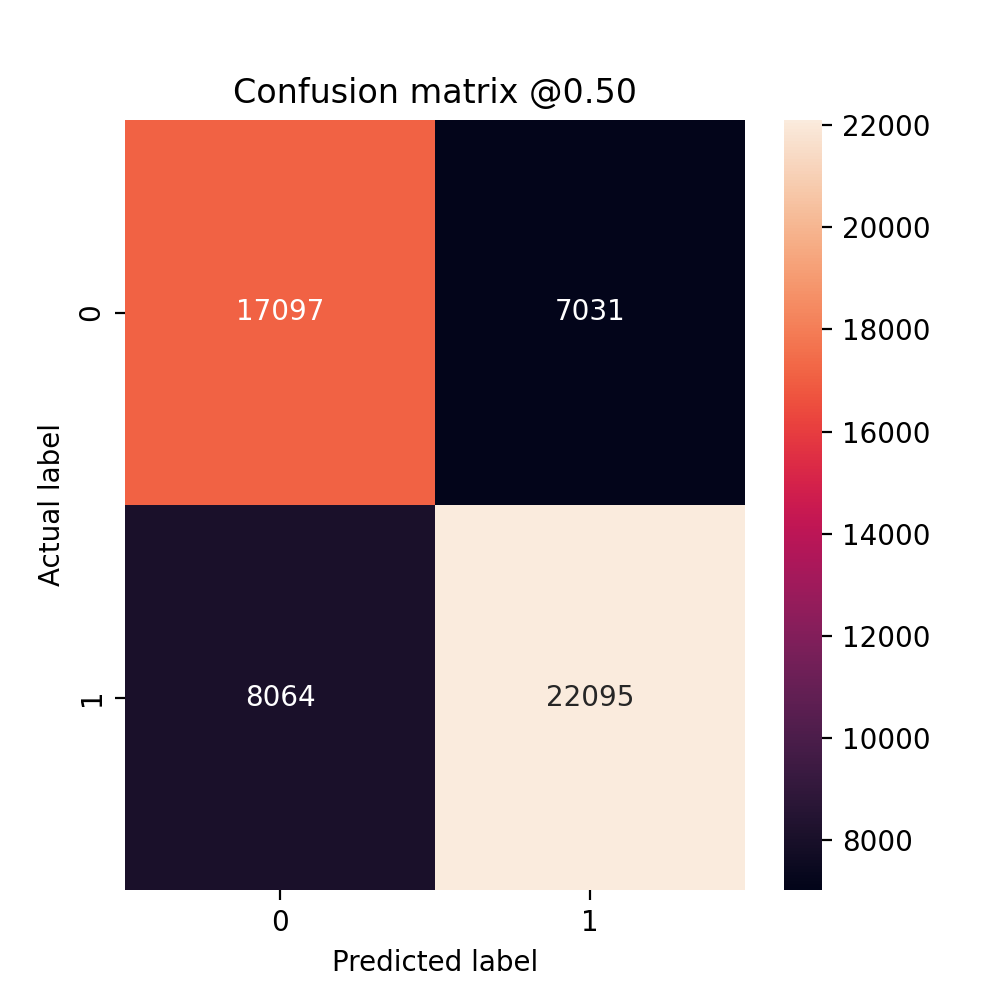

No Flow Detected (True Negatives):  17097
Flow Incorrectly Detected (False Positives):  7031
No Flow Incorrectly Detected (False Negatives):  8064
Flow Detected (True Positives):  22095
Total Flow Detected:  30159
0.7219407961390388


In [168]:
baseline.plot_cm()

### Resampling

In [169]:
def resample(df_data, target = "Powder", n = 10000):
    grouped_df = df_data.groupby('Powder')
    # create a new dataframe to hold the resampled rows
    resampled_df = pd.DataFrame()

    # for each group in the grouped dataframe
    for name, group in grouped_df:
        # if the number of rows in the group is greater than n
        if len(group) > n:
            # undersample the group without replacement
            resampled_group = group.sample(n=n, replace=False)
        else:
            # oversample the group with replacement
            resampled_group = group.sample(n=n, replace=True)
        # append the resampled group to the resampled dataframe
        resampled_df = pd.concat([resampled_df, resampled_group], axis = 0)

    # print the resampled dataframe
    resampled_df = resampled_df.reset_index(drop = True)

    return resampled_df

In [170]:
resampled_df = resample(df_data)


le = LabelEncoder()
resampled_df['Powder Class'] = le.fit_transform(resampled_df['Powder'])#type: ignore
num_classes = len(le.classes_)
counts = np.bincount(resampled_df['Powder Class']) 
total = sum(counts)

for label,count in zip(le.classes_,counts):
    print(f"Label {label} : {count} ({count/total * 100:.2f}% of total)")
    break

print(resampled_df)
resampled_df.pop('Powder')
resampled_df.pop('Flow Class')
resampled_df.pop('Flow')

class_labels = resampled_df.pop('Powder Class')

Label AEE_WP-301_1-5_AA_3-7.txt : 10000 (3.03% of total)
            Da      Dp  FWidth  FLength  ELength  EWidth    Volume     Area  \
0        5.031   5.400   4.620    6.292    5.686   4.360    66.676   19.879   
1        8.528  10.054   6.740   12.675   11.826   6.319   324.702   57.115   
2        4.600   4.854   3.864    5.739    5.330   3.834    50.958   16.617   
3        4.988   5.849   4.805    6.276    5.823   4.403    64.974   19.540   
4       12.357  18.441  12.168   17.199   13.644  11.552   988.027  119.932   
...        ...     ...     ...      ...      ...     ...       ...      ...   
329995   6.935   7.618   6.730    8.228    7.895   6.192   174.610   37.769   
329996  10.002  11.648   7.583   14.509   14.340   7.057   523.898   78.570   
329997  12.027  12.929  10.206   14.509   14.227  10.191   910.950  113.611   
329998  11.233  12.056  11.076   12.783   11.721  10.864   742.230   99.110   
329999  13.945  14.568  12.720   15.974   15.742  12.375  1419.936  152.73

## Flow Class Resample

In [171]:
powder_balanced_df = resample(df_data)

powder_balanced_df.pop("Powder")
powder_balanced_df.pop("Flow")

neg, pos = np.bincount(powder_balanced_df['Flow Class']) #type: ignore
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 330000
    Positive: 240000 (72.73% of total)



In [174]:
balanced_model = Model(name = "Balanced Model", num_classes= 2)

balanced_model.split_transform_data(powder_balanced_df)

balanced_model.apply_StandardScaler()

Training labels shape: (211200,)
Validation labels shape: (52800,)
Test labels shape: (66000,)
Training features shape: (211200, 27)
Validation features shape: (52800, 27)
Test features shape: (66000, 27)


In [175]:
model = balanced_model.make_model()
history = balanced_model.fit_model()
# IPython.display.clear_output()
balanced_model.evaluate_model()

Epoch 1/100
104/104 [==============================] - 2s 8ms/step - loss: 0.5629 - tp: 224701.0000 - fp: 79486.0000 - tn: 54748.0000 - fn: 25981.0000 - accuracy: 0.7260 - precision: 0.7387 - recall: 0.8964 - auc: 0.7337 - prc: 0.8285 - val_loss: 0.5147 - val_tp: 38473.0000 - val_fp: 14327.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.7287 - val_precision: 0.7287 - val_recall: 1.0000 - val_auc: 0.7856 - val_prc: 0.9168
Epoch 2/100
104/104 [==============================] - 0s 2ms/step - loss: 0.5102 - tp: 152982.0000 - fp: 56771.0000 - tn: 839.0000 - fn: 608.0000 - accuracy: 0.7283 - precision: 0.7293 - recall: 0.9960 - auc: 0.7432 - prc: 0.8960 - val_loss: 0.4854 - val_tp: 38473.0000 - val_fp: 14327.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.7287 - val_precision: 0.7287 - val_recall: 1.0000 - val_auc: 0.7878 - val_prc: 0.9174
Epoch 3/100
104/104 [==============================] - 0s 2ms/step - loss: 0.4937 - tp: 149162.0000 - fp: 51880.0000 - t

Epoch 20/100
104/104 [==============================] - 0s 2ms/step - loss: 0.4705 - tp: 144717.0000 - fp: 44940.0000 - tn: 12670.0000 - fn: 8873.0000 - accuracy: 0.7452 - precision: 0.7630 - recall: 0.9422 - auc: 0.7842 - prc: 0.9145 - val_loss: 0.4604 - val_tp: 36220.0000 - val_fp: 10802.0000 - val_tn: 3525.0000 - val_fn: 2253.0000 - val_accuracy: 0.7527 - val_precision: 0.7703 - val_recall: 0.9414 - val_auc: 0.7953 - val_prc: 0.9203
Epoch 21/100
104/104 [==============================] - 0s 2ms/step - loss: 0.4709 - tp: 144687.0000 - fp: 44689.0000 - tn: 12921.0000 - fn: 8903.0000 - accuracy: 0.7462 - precision: 0.7640 - recall: 0.9420 - auc: 0.7842 - prc: 0.9143 - val_loss: 0.4603 - val_tp: 36090.0000 - val_fp: 10654.0000 - val_tn: 3673.0000 - val_fn: 2383.0000 - val_accuracy: 0.7531 - val_precision: 0.7721 - val_recall: 0.9381 - val_auc: 0.7955 - val_prc: 0.9204
Epoch 22/100
104/104 [==============================] - 0s 2ms/step - loss: 0.4706 - tp: 144532.0000 - fp: 44700.0000 - 

Epoch 39/100
104/104 [==============================] - 0s 2ms/step - loss: 0.4693 - tp: 144598.0000 - fp: 44412.0000 - tn: 13198.0000 - fn: 8992.0000 - accuracy: 0.7471 - precision: 0.7650 - recall: 0.9415 - auc: 0.7853 - prc: 0.9149 - val_loss: 0.4598 - val_tp: 35765.0000 - val_fp: 10274.0000 - val_tn: 4053.0000 - val_fn: 2708.0000 - val_accuracy: 0.7541 - val_precision: 0.7768 - val_recall: 0.9296 - val_auc: 0.7962 - val_prc: 0.9206
Epoch 40/100
104/104 [==============================] - 0s 2ms/step - loss: 0.4696 - tp: 144634.0000 - fp: 44562.0000 - tn: 13048.0000 - fn: 8956.0000 - accuracy: 0.7466 - precision: 0.7645 - recall: 0.9417 - auc: 0.7847 - prc: 0.9148 - val_loss: 0.4603 - val_tp: 36086.0000 - val_fp: 10627.0000 - val_tn: 3700.0000 - val_fn: 2387.0000 - val_accuracy: 0.7535 - val_precision: 0.7725 - val_recall: 0.9380 - val_auc: 0.7961 - val_prc: 0.9207
Epoch 41/100
104/104 [==============================] - 0s 2ms/step - loss: 0.4693 - tp: 144526.0000 - fp: 44571.0000 - 

Epoch 58/100
104/104 [==============================] - 0s 2ms/step - loss: 0.4685 - tp: 144805.0000 - fp: 44739.0000 - tn: 12871.0000 - fn: 8785.0000 - accuracy: 0.7466 - precision: 0.7640 - recall: 0.9428 - auc: 0.7853 - prc: 0.9152 - val_loss: 0.4596 - val_tp: 35949.0000 - val_fp: 10479.0000 - val_tn: 3848.0000 - val_fn: 2524.0000 - val_accuracy: 0.7537 - val_precision: 0.7743 - val_recall: 0.9344 - val_auc: 0.7965 - val_prc: 0.9208
Epoch 59/100
104/104 [==============================] - 0s 2ms/step - loss: 0.4686 - tp: 144600.0000 - fp: 44602.0000 - tn: 13008.0000 - fn: 8990.0000 - accuracy: 0.7462 - precision: 0.7643 - recall: 0.9415 - auc: 0.7852 - prc: 0.9152 - val_loss: 0.4600 - val_tp: 36264.0000 - val_fp: 10829.0000 - val_tn: 3498.0000 - val_fn: 2209.0000 - val_accuracy: 0.7531 - val_precision: 0.7701 - val_recall: 0.9426 - val_auc: 0.7965 - val_prc: 0.9207
Epoch 60/100
104/104 [==============================] - 0s 2ms/step - loss: 0.4690 - tp: 144641.0000 - fp: 44420.0000 - 

Epoch 77/100
104/104 [==============================] - 0s 2ms/step - loss: 0.4690 - tp: 144615.0000 - fp: 44556.0000 - tn: 13054.0000 - fn: 8975.0000 - accuracy: 0.7465 - precision: 0.7645 - recall: 0.9416 - auc: 0.7851 - prc: 0.9151 - val_loss: 0.4598 - val_tp: 35902.0000 - val_fp: 10382.0000 - val_tn: 3945.0000 - val_fn: 2571.0000 - val_accuracy: 0.7547 - val_precision: 0.7757 - val_recall: 0.9332 - val_auc: 0.7969 - val_prc: 0.9209
Epoch 78/100
104/104 [==============================] - 0s 2ms/step - loss: 0.4692 - tp: 144601.0000 - fp: 44406.0000 - tn: 13204.0000 - fn: 8989.0000 - accuracy: 0.7472 - precision: 0.7651 - recall: 0.9415 - auc: 0.7852 - prc: 0.9150 - val_loss: 0.4592 - val_tp: 35965.0000 - val_fp: 10486.0000 - val_tn: 3841.0000 - val_fn: 2508.0000 - val_accuracy: 0.7539 - val_precision: 0.7743 - val_recall: 0.9348 - val_auc: 0.7967 - val_prc: 0.9209
Epoch 79/100
104/104 [==============================] - 0s 2ms/step - loss: 0.4689 - tp: 144631.0000 - fp: 44443.0000 - 

Epoch 96/100
104/104 [==============================] - 0s 2ms/step - loss: 0.4688 - tp: 144672.0000 - fp: 44509.0000 - tn: 13101.0000 - fn: 8918.0000 - accuracy: 0.7470 - precision: 0.7647 - recall: 0.9419 - auc: 0.7858 - prc: 0.9154 - val_loss: 0.4593 - val_tp: 36179.0000 - val_fp: 10732.0000 - val_tn: 3595.0000 - val_fn: 2294.0000 - val_accuracy: 0.7533 - val_precision: 0.7712 - val_recall: 0.9404 - val_auc: 0.7970 - val_prc: 0.9210
Epoch 97/100
104/104 [==============================] - 0s 2ms/step - loss: 0.4688 - tp: 144595.0000 - fp: 44518.0000 - tn: 13092.0000 - fn: 8995.0000 - accuracy: 0.7466 - precision: 0.7646 - recall: 0.9414 - auc: 0.7856 - prc: 0.9151 - val_loss: 0.4591 - val_tp: 35769.0000 - val_fp: 10245.0000 - val_tn: 4082.0000 - val_fn: 2704.0000 - val_accuracy: 0.7548 - val_precision: 0.7774 - val_recall: 0.9297 - val_auc: 0.7972 - val_prc: 0.9210
Epoch 98/100
104/104 [==============================] - 0s 2ms/step - loss: 0.4684 - tp: 144632.0000 - fp: 44515.0000 - 

<IPython.core.display.Javascript object>


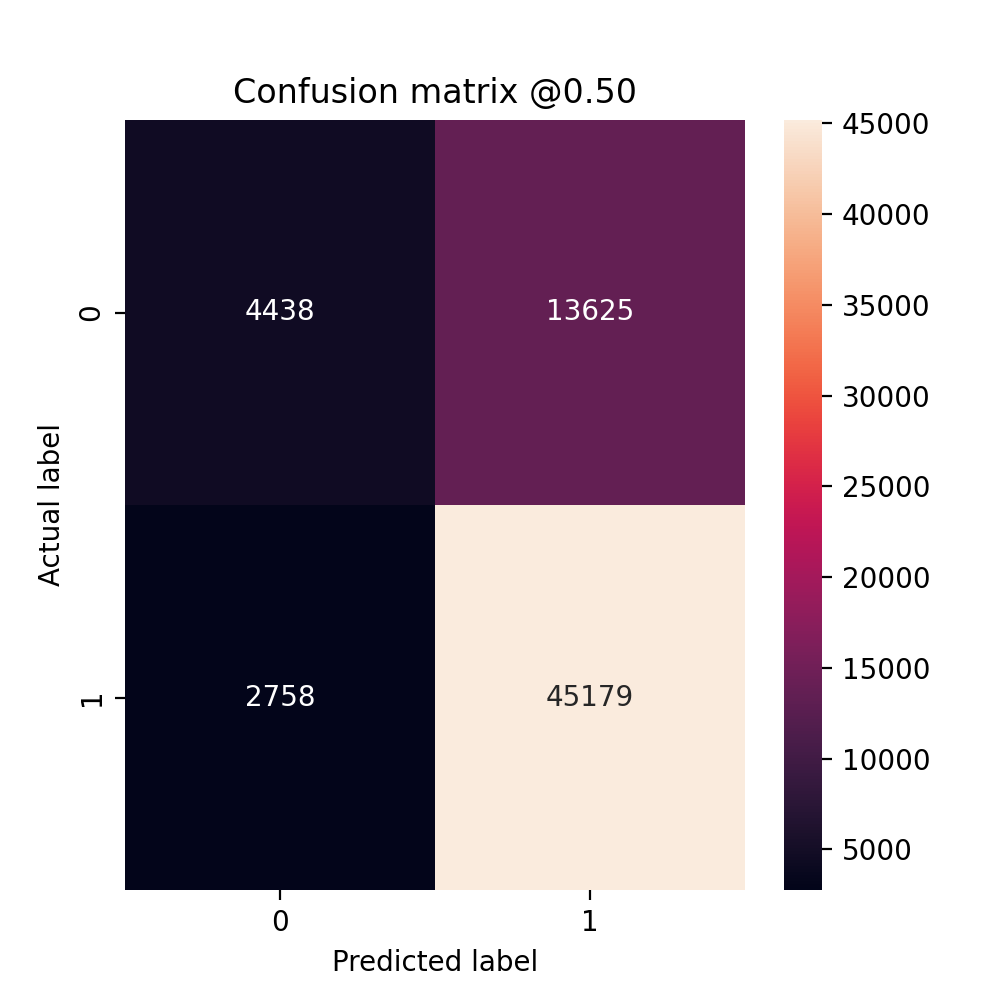

No Flow Detected (True Negatives):  4438
Flow Incorrectly Detected (False Positives):  13625
No Flow Incorrectly Detected (False Negatives):  2758
Flow Detected (True Positives):  45179
Total Flow Detected:  47937
0.7517727272727273


In [176]:
balanced_model.plot_cm()

## Let's try again

In [177]:
ae_model = Model(name = "Autoencoder Model", num_classes = 2)

ae_model.split_transform_data(powder_balanced_df)

ae_model.apply_StandardScaler()

train_x = balanced_model.train_features
## input layer 
input_layer = keras.Input(shape=(train_x.shape[1],))

## encoding part
encoded = keras.layers.Dense(100, activation='tanh', activity_regularizer=keras.regularizers.l1(10e-5))(input_layer)
encoded = keras.layers.Dense(50, activation='relu')(encoded)

## decoding part
decoded = keras.layers.Dense(50, activation='tanh')(encoded)
decoded = keras.layers.Dense(100, activation='tanh')(decoded)

## output layer
output_layer = keras.layers.Dense(train_x.shape[1], activation='relu')(decoded)

Training labels shape: (211200,)
Validation labels shape: (52800,)
Test labels shape: (66000,)
Training features shape: (211200, 27)
Validation features shape: (52800, 27)
Test features shape: (66000, 27)


In [178]:
from keras.models import Model, Sequential

autoencoder = Model(input_layer, output_layer)
autoencoder.compile(optimizer="adadelta", loss="mse")

In [182]:
x = powder_balanced_df.drop(["Flow Class"], axis=1)
y = powder_balanced_df["Flow Class"].values
x_scale = MinMaxScaler().fit_transform(x.values)
x_norm, x_fraud = x_scale[y == 0], x_scale[y == 1]
x

,Da,Dp,FWidth,FLength,ELength,EWidth,Volume,Area,Perimeter,CHull Area,CHull Perimeter,Sphericity,Compactness,Roundness,Ellipse Ratio,Circularity,Solidity,Concavity,Convexity,Extent,Transparency,Curvature,Surface Area,L/W Ratio,W/L Aspect Ratio,CHull Surface Area,Ellipticity
0,15.802,23.060,14.934,25.210,22.388,12.996,2066.192,196.127,72.445,251.067,65.133,0.685,0.627,0.393,0.581,0.470,0.781,0.219,0.899,0.521,0.375,0.0,784.509,1.688,0.592,1004.266,1.723
1,7.921,10.762,7.290,13.781,10.341,6.370,260.265,49.283,33.810,58.736,32.294,0.736,0.575,0.330,0.616,0.542,0.839,0.161,0.955,0.491,0.389,0.0,197.134,1.890,0.529,234.944,1.623
2,9.847,10.999,8.059,13.049,12.899,7.639,499.869,76.149,34.554,79.516,34.369,0.895,0.755,0.569,0.592,0.801,0.958,0.042,0.995,0.724,0.379,0.0,304.594,1.619,0.618,318.064,1.689
3,10.260,11.020,9.309,12.573,11.978,8.792,565.478,82.674,34.620,85.432,34.237,0.931,0.816,0.666,0.734,0.867,0.968,0.032,0.989,0.706,0.386,0.0,330.695,1.351,0.740,341.729,1.362
4,11.722,13.077,9.809,15.066,14.450,9.587,843.362,107.920,41.083,114.306,39.903,0.896,0.778,0.605,0.663,0.804,0.944,0.056,0.971,0.730,0.360,0.0,431.678,1.536,0.651,457.222,1.507
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
329995,7.946,8.897,7.236,9.824,9.352,6.831,262.727,49.594,27.951,53.883,27.417,0.893,0.809,0.654,0.730,0.798,0.920,0.080,0.981,0.698,0.403,0.0,198.375,1.358,0.737,215.533,1.369
329996,13.336,13.863,12.972,14.348,13.624,13.092,1241.913,139.686,43.553,143.225,43.233,0.962,0.930,0.864,0.961,0.925,0.975,0.025,0.993,0.751,0.375,0.0,558.742,1.106,0.904,572.901,1.041
329997,16.538,17.203,15.565,18.249,18.093,15.138,2368.486,214.818,54.046,219.517,53.454,0.961,0.906,0.821,0.837,0.924,0.979,0.021,0.989,0.756,0.363,0.0,859.273,1.172,0.853,878.068,1.195
329998,12.192,15.656,12.295,14.560,13.738,10.919,948.881,116.743,49.186,136.659,42.702,0.779,0.837,0.701,0.795,0.606,0.854,0.146,0.868,0.652,0.406,0.0,466.973,1.184,0.844,546.635,1.258


In [183]:
autoencoder.fit(x_norm, x_norm, 
                batch_size = 256, epochs = 20, 
                shuffle = True, validation_split = 0.20);

Epoch 1/20
282/282 [==============================] - 1s 2ms/step - loss: 0.1703 - val_loss: 0.1473
Epoch 2/20
282/282 [==============================] - 0s 1ms/step - loss: 0.1582 - val_loss: 0.1339
Epoch 3/20
282/282 [==============================] - 0s 1ms/step - loss: 0.1413 - val_loss: 0.1194
Epoch 4/20
282/282 [==============================] - 0s 1ms/step - loss: 0.1257 - val_loss: 0.1068
Epoch 5/20
282/282 [==============================] - 0s 1ms/step - loss: 0.1124 - val_loss: 0.0964
Epoch 6/20
282/282 [==============================] - 0s 1ms/step - loss: 0.1015 - val_loss: 0.0881
Epoch 7/20
282/282 [==============================] - 0s 1ms/step - loss: 0.0930 - val_loss: 0.0820
Epoch 8/20
282/282 [==============================] - 0s 1ms/step - loss: 0.0867 - val_loss: 0.0777
Epoch 9/20
282/282 [==============================] - 0s 1ms/step - loss: 0.0824 - val_loss: 0.0750
Epoch 10/20
282/282 [==============================] - 0s 2ms/step - loss: 0.0796 - val_loss: 0.0734

In [184]:
hidden_representation = Sequential()
hidden_representation.add(autoencoder.layers[0])
hidden_representation.add(autoencoder.layers[1])
hidden_representation.add(autoencoder.layers[2])

In [193]:
print(x_norm.shape)
print(x_fraud.shape)
# norm_hid_rep = hidden_representation.predict(x_norm[:10000])
# fraud_hid_rep = hidden_representation.predict(x_fraud[:10000])
norm_hid_rep = hidden_representation.predict(x_norm[:10000])
fraud_hid_rep = hidden_representation.predict(x_fraud[:10000])
# norm_hid_rep = hidden_representation.predict(x_norm)
# fraud_hid_rep = hidden_representation.predict(x_fraud)

(90000, 27)
(240000, 27)


In [194]:
from sklearn.manifold import TSNE
import matplotlib.animation as animation

def tsne_plot(x1, y1, name="graph.png"):
    tsne = TSNE(n_components=3, random_state=0)
    X_t = tsne.fit_transform(x1)
    print(X_t)
    fig = plt.figure()
    
    ax = fig.add_subplot(111, projection='3d')
    ax.view_init(45,60)
    
#     print(X_t[np.where(y1 == 0), 0])
    plot_ = ax.scatter3D(X_t[np.where(y1 == 0), 0], X_t[np.where(y1 == 0), 1], X_t[np.where(y1 == 0), 2], marker='*', cmap='YlOrRd', alpha=0.8, label='No Flow')
    plot_ = ax.scatter3D(X_t[np.where(y1 == 1), 0], X_t[np.where(y1 == 1), 1], X_t[np.where(y1 == 1), 2], marker='o', cmap='BuPu', alpha=0.8, label='Flow')

#     plt.legend(loc='best');
#     plt.savefig(name);
    
    plt.show();
    
    
rep_x = np.append(norm_hid_rep, fraud_hid_rep, axis = 0)
y_n = np.zeros(norm_hid_rep.shape[0])
y_f = np.ones(fraud_hid_rep.shape[0])
rep_y = np.append(y_n, y_f)
print(rep_x.shape)
print(rep_y.shape)
# tsne_plot(rep_x, rep_y, "./latent_representation.png")



(20000, 50)
(20000,)


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


<IPython.core.display.Javascript object>


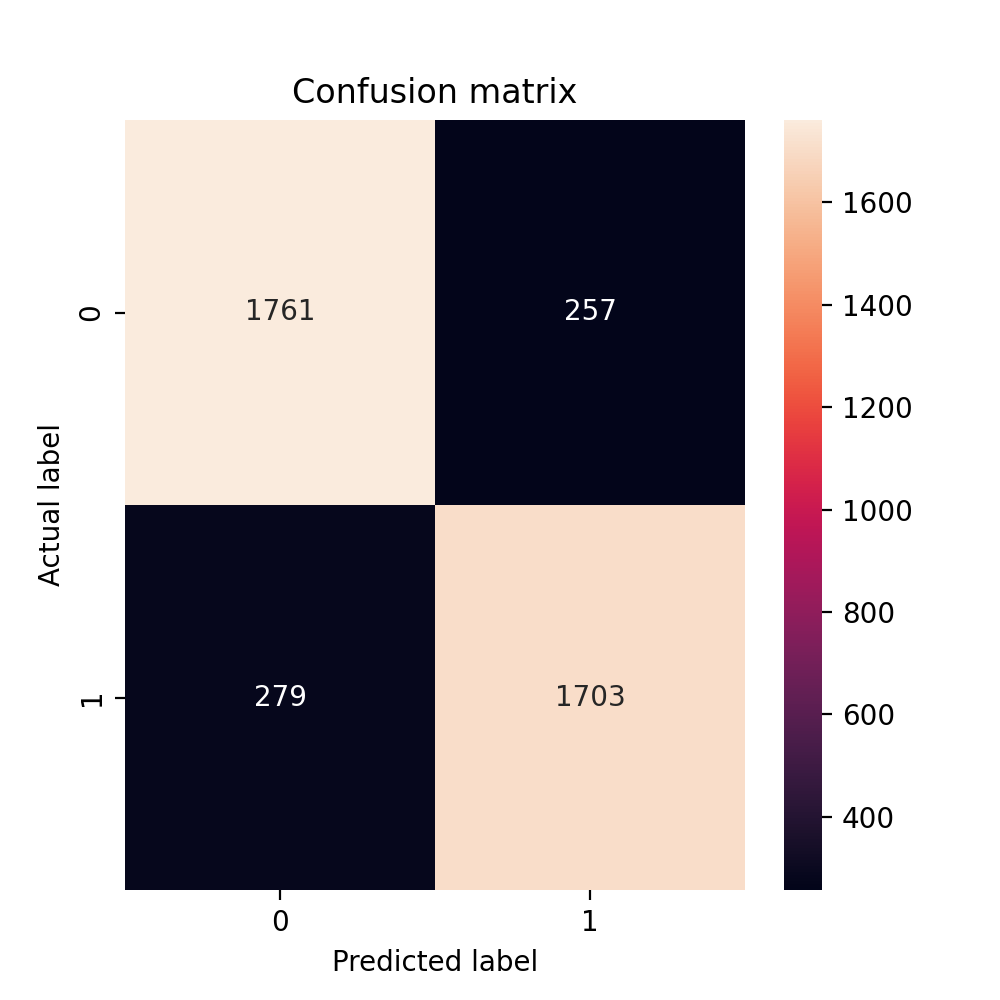

No Flow Detected (True Negatives):  1761
Flow Incorrectly Detected (False Positives):  257
No Flow Incorrectly Detected (False Negatives):  279
Flow Detected (True Positives):  1703
Total Flow Detected:  1982
0.866


In [195]:
from sklearn.linear_model import LogisticRegression

train_x, val_x, train_y, val_y = train_test_split(rep_x, rep_y, test_size=0.2)

clf = LogisticRegression(solver="lbfgs").fit(train_x, train_y)
pred_y = clf.predict(val_x)

# print ("")
# print ("Classification Report: ")
# print (classification_report(val_y, pred_y))

# print ("")
# print ("Accuracy Score: ", accuracy_score(val_y, pred_y))

cm = confusion_matrix(val_y, pred_y)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

print('No Flow Detected (True Negatives): ', cm[0][0])
print('Flow Incorrectly Detected (False Positives): ', cm[0][1])
print('No Flow Incorrectly Detected (False Negatives): ', cm[1][0])
print('Flow Detected (True Positives): ', cm[1][1])
print('Total Flow Detected: ', np.sum(cm[1]))
print((cm[0][0] + cm[1][1]) / (cm[0][0] +  cm[0][1] + cm[1][0] +cm[1][1]))

In [196]:
model = keras.Sequential([
          keras.layers.Dense(
              256, activation='tanh',
              input_shape=(train_x.shape[-1],)),
        keras.layers.Dense(
              128, activation='tanh'),
        keras.layers.Dense(
              64, activation='tanh'),
        keras.layers.Dense(
              32, activation='tanh'),
         keras.layers.Dense(
              16, activation='tanh'),
              keras.layers.Dense(
              8, activation='tanh'),
#           keras.layers.Dropout(0.5),
          keras.layers.Dense(1, activation='sigmoid'),
      ])

model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=1e-4),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=['accuracy'])

model.fit(train_x,
    train_y,
    batch_size=1024,
    epochs=100)

results = model.evaluate(train_x, train_y, batch_size = 1024, verbose=0)


Epoch 1/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6803 - accuracy: 0.5744
Epoch 2/100
16/16 [==============================] - 0s 5ms/step - loss: 0.6325 - accuracy: 0.7057
Epoch 3/100
16/16 [==============================] - 0s 4ms/step - loss: 0.5912 - accuracy: 0.7305
Epoch 4/100
16/16 [==============================] - 0s 4ms/step - loss: 0.5586 - accuracy: 0.7449
Epoch 5/100
16/16 [==============================] - 0s 4ms/step - loss: 0.5314 - accuracy: 0.7585
Epoch 6/100
16/16 [==============================] - 0s 4ms/step - loss: 0.5110 - accuracy: 0.7657
Epoch 7/100
16/16 [==============================] - 0s 4ms/step - loss: 0.4927 - accuracy: 0.7776
Epoch 8/100
16/16 [==============================] - 0s 5ms/step - loss: 0.4773 - accuracy: 0.7854
Epoch 9/100
16/16 [==============================] - 0s 4ms/step - loss: 0.4619 - accuracy: 0.7947
Epoch 10/100
16/16 [==============================] - 0s 4ms/step - loss: 0.4474 - accuracy: 0.8047
Epoch 11/

16/16 [==============================] - 0s 5ms/step - loss: 0.2653 - accuracy: 0.8898
Epoch 84/100
16/16 [==============================] - 0s 5ms/step - loss: 0.2651 - accuracy: 0.8885
Epoch 85/100
16/16 [==============================] - 0s 4ms/step - loss: 0.2637 - accuracy: 0.8891
Epoch 86/100
16/16 [==============================] - 0s 5ms/step - loss: 0.2655 - accuracy: 0.8879
Epoch 87/100
16/16 [==============================] - 0s 5ms/step - loss: 0.2624 - accuracy: 0.8903
Epoch 88/100
16/16 [==============================] - 0s 5ms/step - loss: 0.2624 - accuracy: 0.8898
Epoch 89/100
16/16 [==============================] - 0s 4ms/step - loss: 0.2638 - accuracy: 0.8896
Epoch 90/100
16/16 [==============================] - 0s 5ms/step - loss: 0.2671 - accuracy: 0.8849
Epoch 91/100
16/16 [==============================] - 0s 5ms/step - loss: 0.2644 - accuracy: 0.8886
Epoch 92/100
16/16 [==============================] - 0s 5ms/step - loss: 0.2639 - accuracy: 0.8877
Epoch 93/100


[[0.56 ]
 [0.111]
 [0.982]
 ...
 [0.941]
 [0.013]
 [0.888]]


<IPython.core.display.Javascript object>


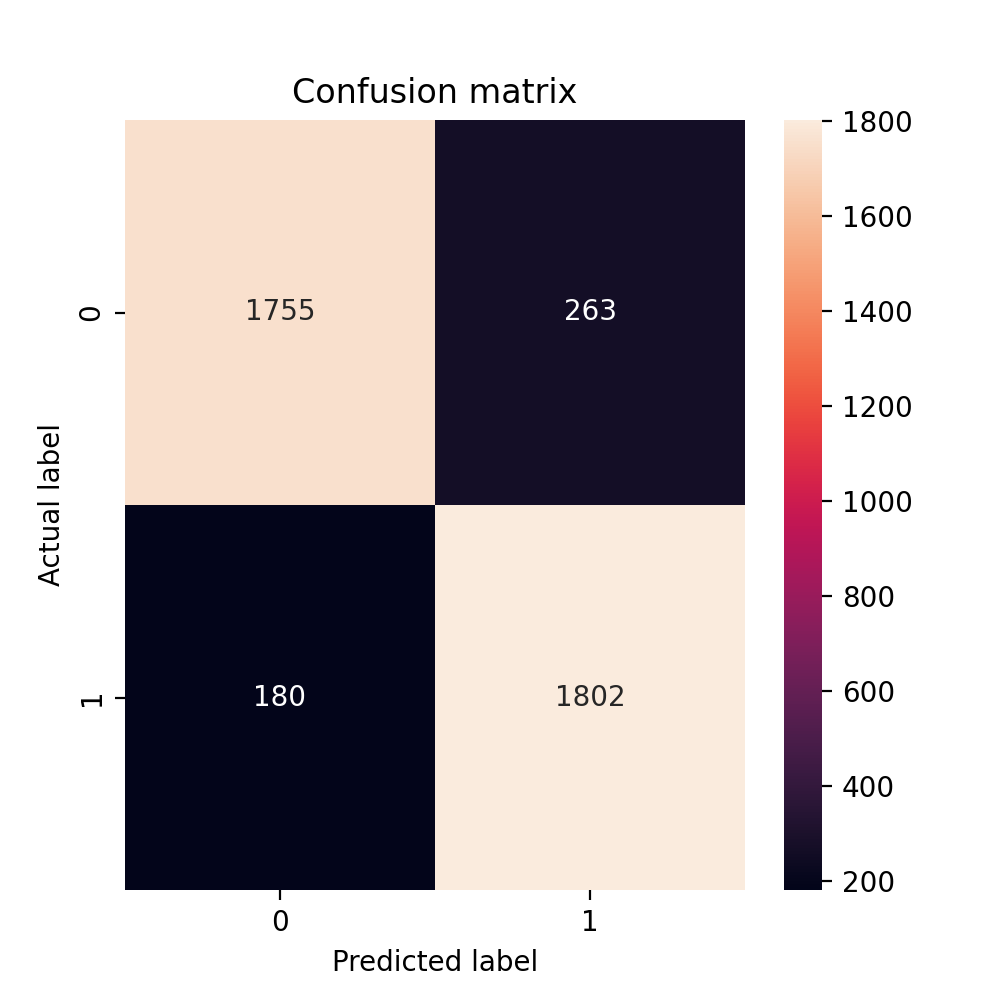

No Flow Detected (True Negatives):  1755
Flow Incorrectly Detected (False Positives):  263
No Flow Incorrectly Detected (False Negatives):  180
Flow Detected (True Positives):  1802
Total Flow Detected:  1982
0.88925


In [197]:
pred_y = model.predict(val_x)
print(pred_y)

cm = confusion_matrix(val_y, pred_y > 0.5)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

print('No Flow Detected (True Negatives): ', cm[0][0])
print('Flow Incorrectly Detected (False Positives): ', cm[0][1])
print('No Flow Incorrectly Detected (False Negatives): ', cm[1][0])
print('Flow Detected (True Positives): ', cm[1][1])
print('Total Flow Detected: ', np.sum(cm[1]))
print((cm[0][0] + cm[1][1]) / (cm[0][0] +  cm[0][1] + cm[1][0] +cm[1][1]))

In [ ]:
import kerastuner as kt

def model_builder1(hp):
    # Initialize the Sequential API and start stacking the layers
#     model = keras.Sequential()
#     model.add(keras.layers.Flatten(input_shape=(27,)))
#     # Tune the number of units in the first Dense layer
#     # Choose an optimal value between 32-512
#     hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
#     model.add(keras.layers.Dense(units=hp_units, activation='relu', name='dense_1'))
#     # Add next layers
#     model.add(keras.layers.Dropout(0.2))
#     model.add(keras.layers.Dense(10, activation='softmax'))
#     # Tune the learning rate for the optimizer
#     # Choose an optimal value from 0.01, 0.001, or 0.0001
#     hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
#     model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
#                 loss=keras.losses.SparseCategoricalCrossentropy(),
#                 metrics=['accuracy'])
    model = keras.Sequential([
          keras.layers.Dense(
              256, activation=hp.Choice('act_0', ['relu', 'sigmoid', 'tanh']),
              input_shape=(train_x.shape[-1],)),
        keras.layers.Dense(
              128, activation=hp.Choice('act_1', ['relu', 'sigmoid', 'tanh'])),
        keras.layers.Dense(
              64, activation=hp.Choice('act_2', ['relu', 'sigmoid', 'tanh'])),
        keras.layers.Dense(
              32, activation=hp.Choice('act_3', ['relu', 'sigmoid', 'tanh'])),
         keras.layers.Dense(
              16, activation=hp.Choice('act_4', ['relu', 'sigmoid', 'tanh'])),
              keras.layers.Dense(
              8, activation=hp.Choice('act_5', ['relu', 'sigmoid', 'tanh'])),
#           keras.layers.Dropout(0.5),
          keras.layers.Dense(1, activation=hp.Choice('act_6', ['relu', 'sigmoid', 'tanh']))
              ])
    model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=['accuracy'])
    return model

In [ ]:
# Instantiate the tuner
tuner = kt.Hyperband(model_builder1, # the hypermodel
                     objective='val_accuracy', # objective to optimize
                        max_epochs=20,
                        factor=3, # factor which you have seen above 
                        directory='dir/f2n', # directory to save logs 
                        project_name='hyperband')

# hypertuning settings
tuner.search_space_summary() 

In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
# Perform hypertuning
tuner.search(train_x, train_y, epochs=10, validation_split=0.2, callbacks=[stop_early])

In [ ]:
best_hp=tuner.get_best_hyperparameters()[0]# Build the model with the optimal hyperparameters

In [ ]:
h_model = tuner.hypermodel.build(best_hp)
h_model.summary()
h_model.fit(train_x, train_y, epochs=50, validation_split=0.2)

In [ ]:
h_eval_dict = h_model.evaluate(val_x, val_y, return_dict=True)

In [ ]:
pred_y = h_model.predict(val_x)
print(pred_y)

cm = confusion_matrix(val_y, pred_y > 0.5)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

print('No Flow Detected (True Negatives): ', cm[0][0])
print('Flow Incorrectly Detected (False Positives): ', cm[0][1])
print('No Flow Incorrectly Detected (False Negatives): ', cm[1][0])
print('Flow Detected (True Positives): ', cm[1][1])
print('Total Flow Detected: ', np.sum(cm[1]))
print((cm[0][0] + cm[1][1]) / (cm[0][0] +  cm[0][1] + cm[1][0] +cm[1][1]))